<font size=6 color='purple'>**Distribution plots**</font>

*Notes:* Initialization cells must be run before plotting, since they define colors and snapshot numbers

Note: all distributions are done with median and simulation stellar mass

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [9]:
plt.rcParams.update({'font.size':20})

# Initialization

In [3]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [4]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


## Function defs

In [5]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [6]:
# functions to get the primaries and secondaries based on AM mass
def get_primaries(sim, phys, size, z, key="Sub1 Mass", groupCut=False, median=False):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_10.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    # get data for unpaired halos first
    unpaired = pair_data["unpaired"][phys]
    unpaired_stells = np.array(unpaired["Sub1 Stellar Mass"])
    unpaired_prims = get_primmask(unpaired_stells, size)
    unpaired_group = get_groupmask(np.array(unpaired["Group Mass"]), size)
    unpaired_median = np.array( unpaired['Realization'] ) ==-1
    
    # get data for paired halos next
    paired = pair_data["pairs"][phys]
    paired_stells = np.array(paired["Sub1 Stellar Mass"])
    paired_prims = get_primmask(paired_stells, size)
    paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
    paired_median = np.array( paired['Realization'] ) ==-1
    
    if groupCut & median:
        unpaired_mask = unpaired_prims & unpaired_group & unpaired_median
        paired_mask = paired_prims & paired_group & paired_median
        
    elif groupCut:
        unpaired_mask = unpaired_prims & unpaired_group 
        paired_mask = paired_prims & paired_group 
        
    elif median:
        unpaired_mask = unpaired_prims & unpaired_median
        paired_mask = paired_prims & paired_median
        
    else:
        unpaired_mask = unpaired_prims        
        paired_mask = paired_prims       
        
    unpaired_key = np.array(unpaired[key])[unpaired_mask]    
    paired_key = np.array(paired[key])[paired_mask]

    catkey = np.concatenate((unpaired_key,paired_key))

    return catkey

def get_secondaries(sim, phys, size, z, key="Sub2 Mass", groupCut=False, median=False):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_10.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    # get data for paired halos next
    paired = pair_data["pairs"][phys]
    paired_stells = np.array(paired["Sub1 Stellar Mass"])
    paired_prims = get_primmask(paired_stells, size)
    paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
    paired_median = np.array( paired['Realization'] ) ==-1
    
    if groupCut & median:
        paired_mask = paired_prims & paired_group & paired_median
        
    elif groupCut:
        paired_mask = paired_prims & paired_group 
        
    elif median:
        paired_mask = paired_prims & paired_median
        
    else:
        paired_mask = paired_prims       
    
    # get the data for those secondaries!
    seco_key = np.array(paired[key])[paired_mask]

    return seco_key


# functions to get the primaries and secondaries based on simulation stellar mass
def get_primaries_simstell(sim, size, z, key="Sub1 Mass", groupCut=False):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]     
        
    pair_path = f"{sim}_{snapshot}_simstars.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    # get data for unpaired halos first
    unpaired = pair_data["unpaired"]["hydro"]
    unpaired_stells = np.array(unpaired["Sub1 Stellar Mass"])
    unpaired_prims = get_primmask(unpaired_stells, size)
    unpaired_group = get_groupmask(np.array(unpaired["Group Mass"]), size)

    # get data for paired halos next
    paired = pair_data["paired"]["hydro"]
    paired_stells = np.array(paired["Sub1 Stellar Mass"])
    paired_prims = get_primmask(paired_stells, size)
    paired_group = get_groupmask(np.array(paired["Group Mass"]), size)    
    
    if groupCut:
        unpaired_mask = unpaired_prims & unpaired_group
        paired_mask = paired_prims & paired_group
    else:
        unpaired_mask = unpaired_prims
        paired_mask = paired_prims
            
    unpaired_key = np.array(unpaired[key])[unpaired_mask]
    paired_key = np.array(paired[key])[paired_mask]

    catkey = np.concatenate((unpaired_key,paired_key))

    return catkey

def get_secondaries_simstell(sim, size, z, key="Sub2 Mass", groupCut=False):
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]      
        
    pair_path = f"{sim}_{snapshot}_simstars.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
    
    # get data for paired halos 
    paired = pair_data["paired"]["hydro"]
    paired_stells = np.array(paired["Sub1 Stellar Mass"])
    paired_prims = get_primmask(paired_stells, size)
    paired_group = get_groupmask(np.array(paired["Group Mass"]), size)

    if groupCut:
        paired_mask = paired_prims & paired_group
    else:
        paired_mask = paired_prims
        
    seco_key = np.array(paired[key])[paired_mask]

    return seco_key

# 

# Group mass

get_primaries(sim, phys, size, z, key="Sub1 Mass", groupCut=False, median=False) 

get_primaries_simstell(sim, size, z, key="Sub1 Mass", groupCut=False)


## Dwarfs

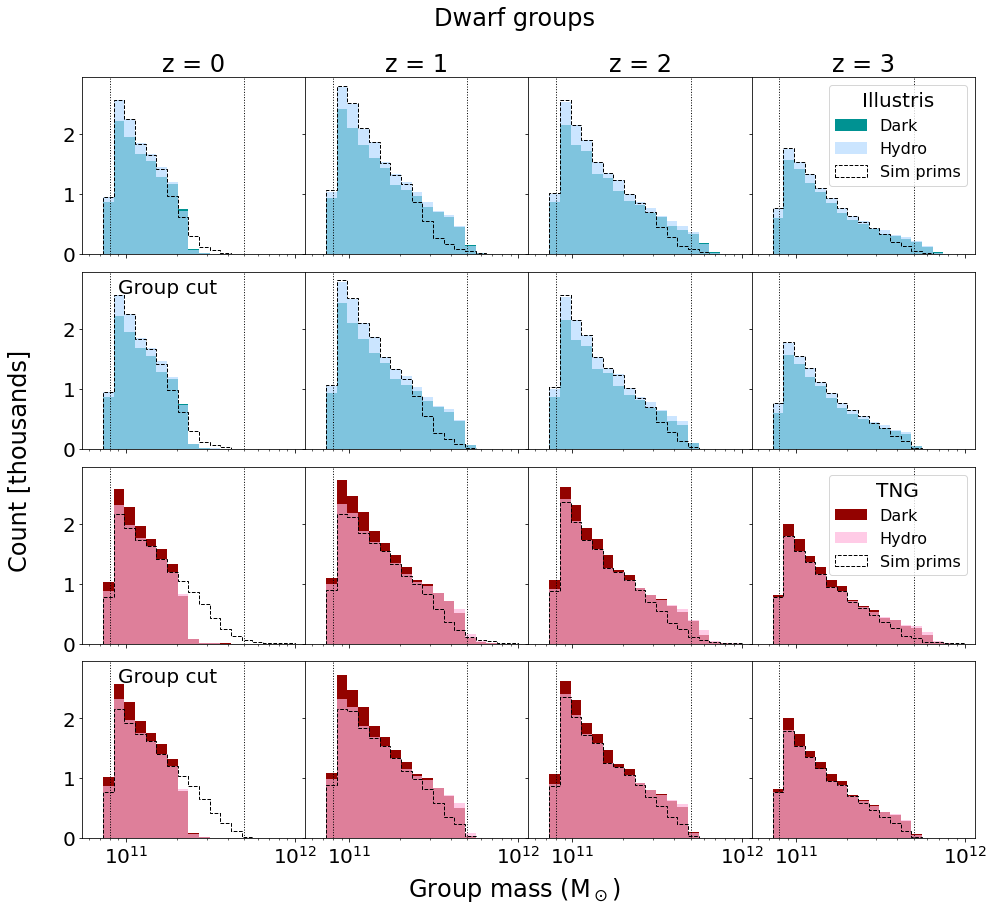

In [18]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.8,12,20)
weight = 1000
key = "Group Mass"
size = "dwarf"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_primaries("Illustris","dark", size, i, key, median=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key)*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    masses = get_primaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key,groupCut=True)*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key)*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    
    masses = get_primaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key,groupCut=True)*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

for i in range(4):
    for j in range(4):
        ax[i][j].axvline(8e10,linestyle='dotted',color='black',lw=1)
        ax[i][j].axvline(5e11,linestyle='dotted',color='black',lw=1)
    
ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(9e10,2.6,"Group cut")
ax[3][0].text(9e10,2.6,"Group cut")

fig.suptitle("Dwarf groups",y=0.95)
fig.supxlabel(r"Group mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/MG_med_d.png",bbox_inches='tight',facecolor="white")
plt.show()

## Massive

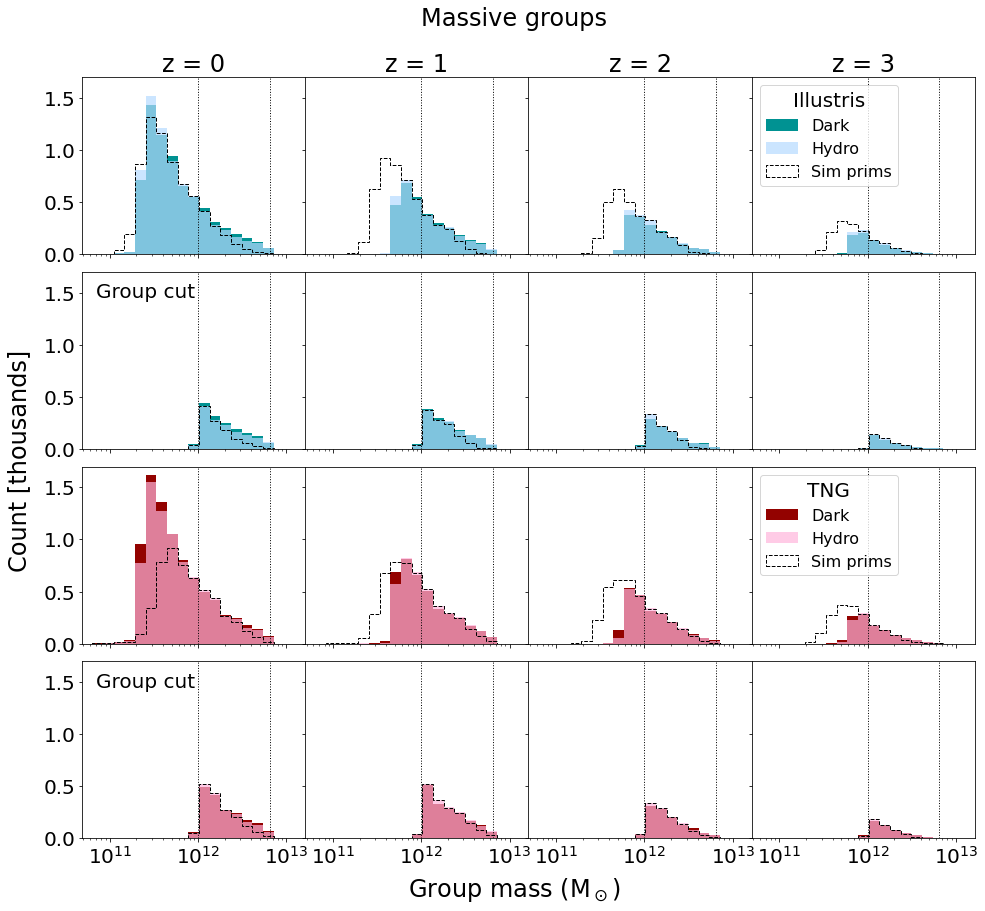

In [17]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.8,13.1,20)
weight = 1000
key = "Group Mass"
size = "massive"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_primaries("Illustris","dark", size, i, key, median=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key)*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    masses = get_primaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key,groupCut=True)*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key)*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    
    masses = get_primaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key,groupCut=True)*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

for i in range(4):
    for j in range(4):
        ax[i][j].axvline(1e12,linestyle='dotted',color='black',lw=1)
        ax[i][j].axvline(6.5e12,linestyle='dotted',color='black',lw=1)

ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(7e10,1.45,"Group cut")
ax[3][0].text(7e10,1.45,"Group cut")

fig.suptitle("Massive groups",y=0.95)
fig.supxlabel(r"Group mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/MG_med_m.png",bbox_inches='tight',facecolor="white")
plt.show()

# Subhalo Mass
## Dwarfs

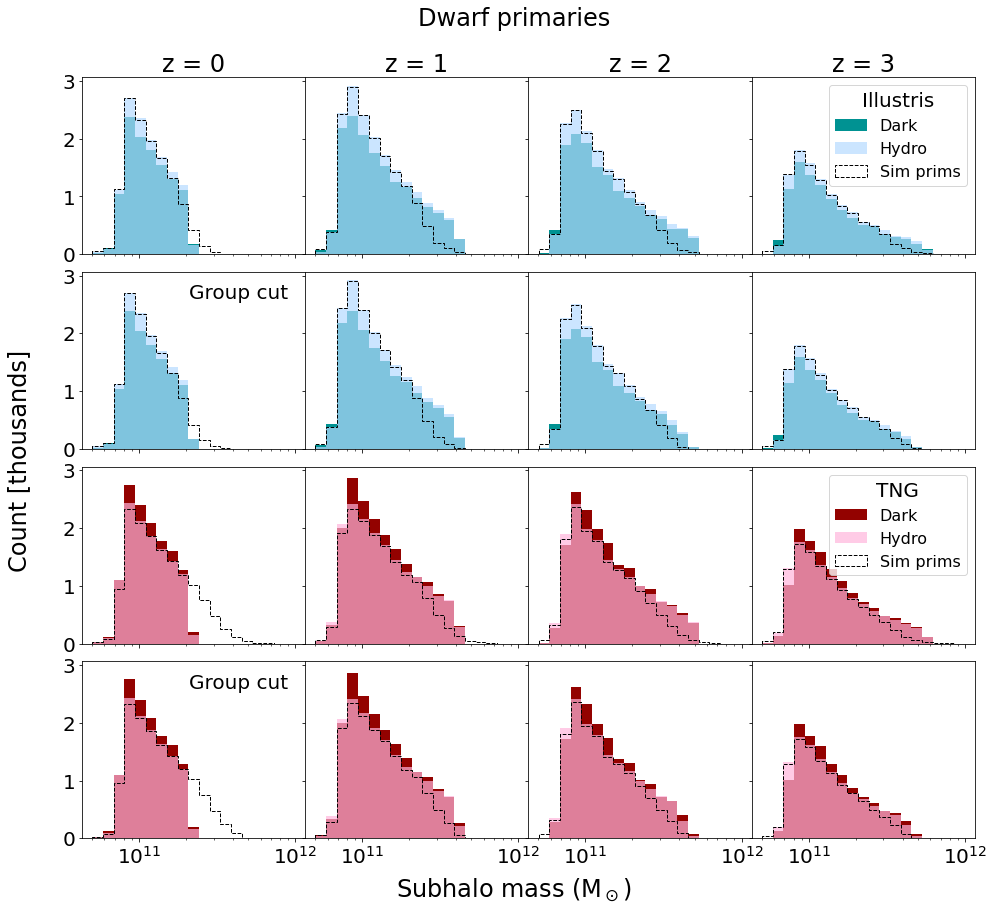

In [15]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,12,20)
weight = 1000
key = "Sub1 Mass"
size = "dwarf"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_primaries("Illustris","dark", size, i, key, median=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key)*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    masses = get_primaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key,groupCut=True)*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key)*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    
    masses = get_primaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key,groupCut=True)*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(9e11,2.6,"Group cut",ha="right")
ax[3][0].text(9e11,2.6,"Group cut",ha="right")

fig.suptitle("Dwarf primaries",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Mh_med_d1.png",bbox_inches='tight',facecolor="white")
plt.show()

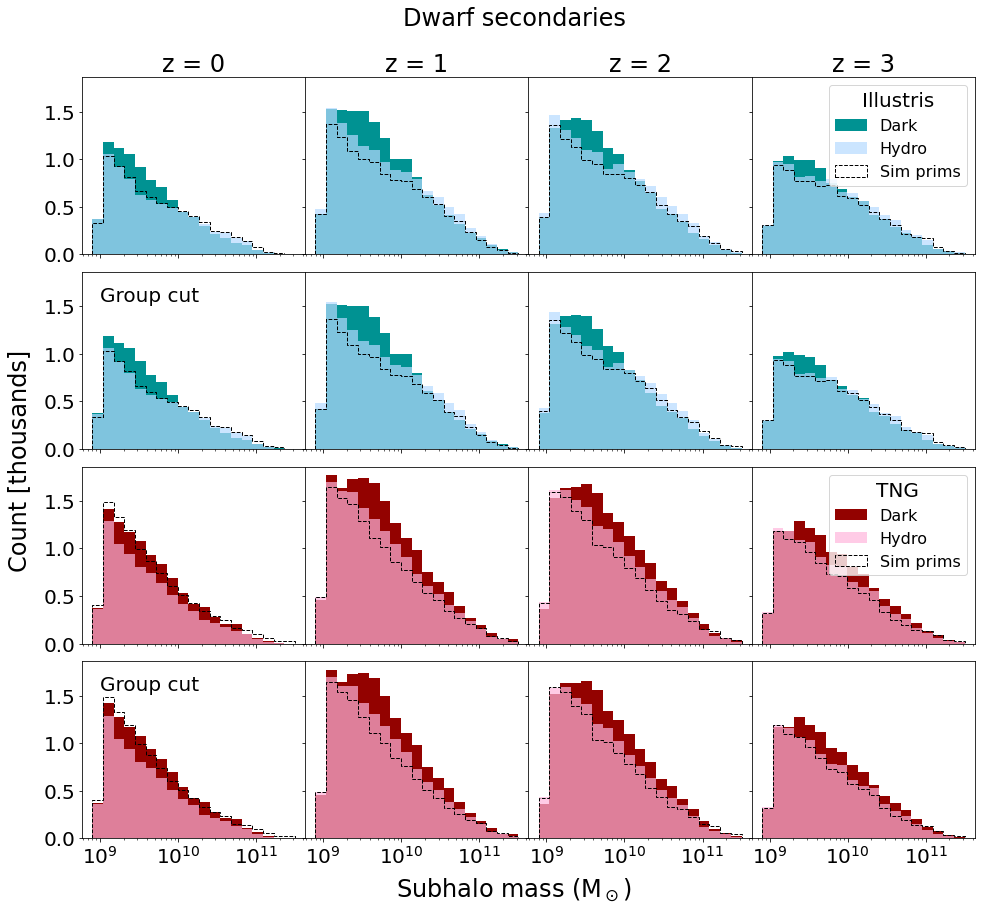

In [16]:
# secondary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(8.9,11.5,20)
weight = 1000
key = "Sub2 Mass"
size = "dwarf"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_secondaries("Illustris","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True)*1e10    
    masses_sim = get_secondaries_simstell("Illustris", size, i, key)*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("Illustris", size, i, key,groupCut=True)*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("TNG","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",  size, i, key)*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    

    masses = get_secondaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",  size, i, key,groupCut=True)*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(1e9,1.55,"Group cut")
ax[3][0].text(1e9,1.55,"Group cut")

fig.suptitle("Dwarf secondaries",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Mh_med_d2.png",bbox_inches='tight',facecolor="white")
plt.show()

## Massive

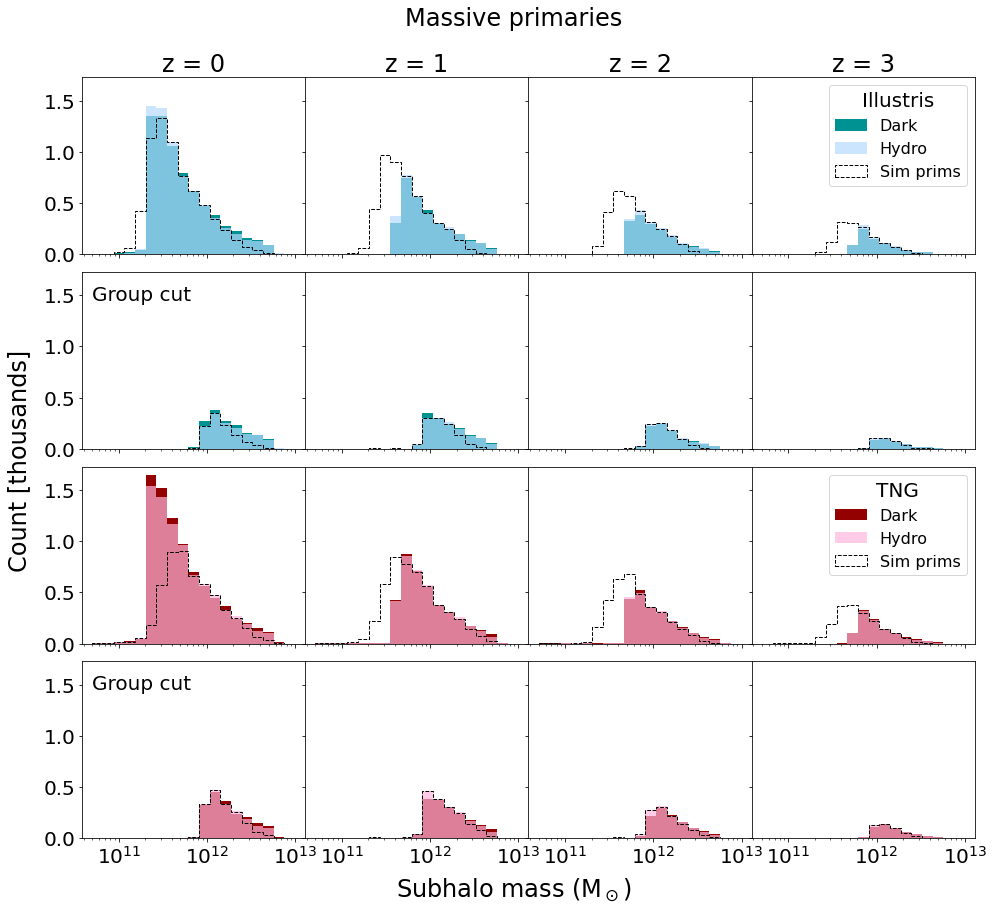

In [17]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.7,13,20)
weight = 1000
key = "Sub1 Mass"
size = "massive"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_primaries("Illustris","dark", size, i, key, median=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key)*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    masses = get_primaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key,groupCut=True)*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key)*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    
    masses = get_primaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key,groupCut=True)*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(5e10,1.45,"Group cut")
ax[3][0].text(5e10,1.45,"Group cut")

fig.suptitle("Massive primaries",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Mh_med_m1.png",bbox_inches='tight',facecolor="white")
plt.show()

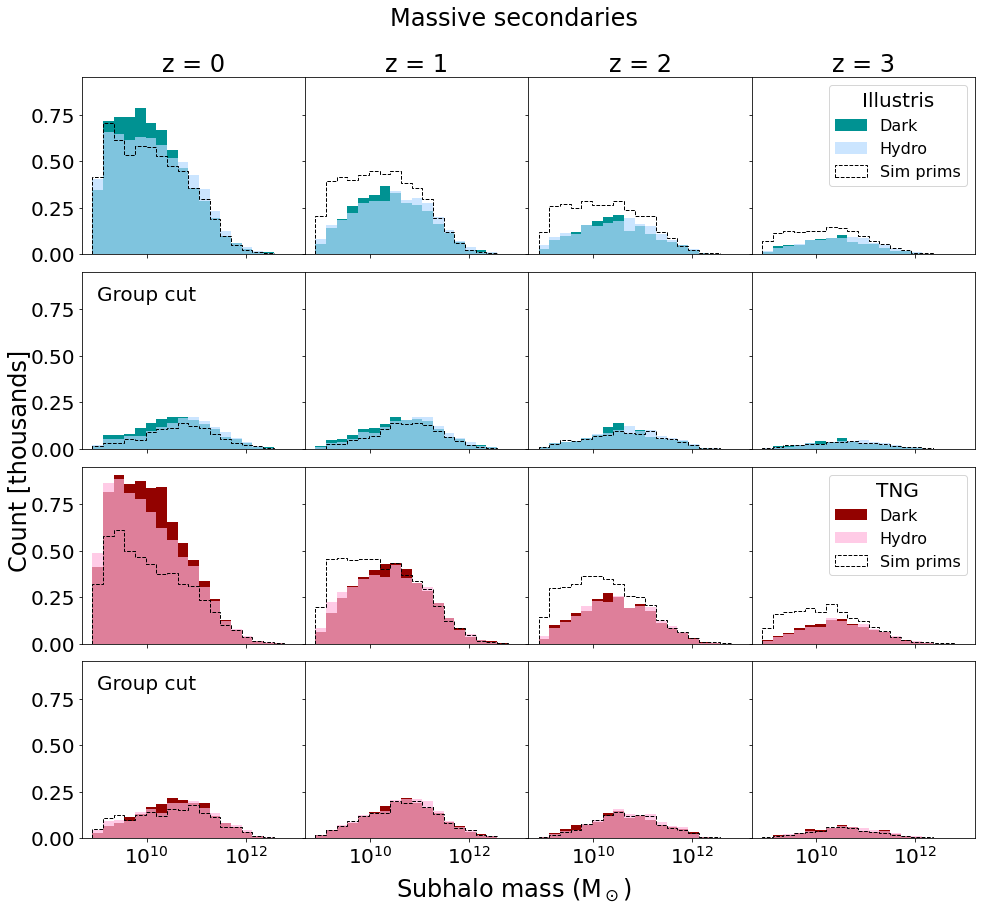

In [18]:
# secondary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(8.9,13,20)
weight = 1000
key = "Sub2 Mass"
size = "massive"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_secondaries("Illustris","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True)*1e10    
    masses_sim = get_secondaries_simstell("Illustris", size, i, key)*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("Illustris", size, i, key,groupCut=True)*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("TNG","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",  size, i, key)*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    

    masses = get_secondaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",  size, i, key,groupCut=True)*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(1e9,0.8,"Group cut")
ax[3][0].text(1e9,0.8,"Group cut")

fig.suptitle("Massive secondaries",y=0.95)
fig.supxlabel(r"Subhalo mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Mh_med_m2.png",bbox_inches='tight',facecolor="white")
plt.show()

# Stellar mass

## Dwarfs

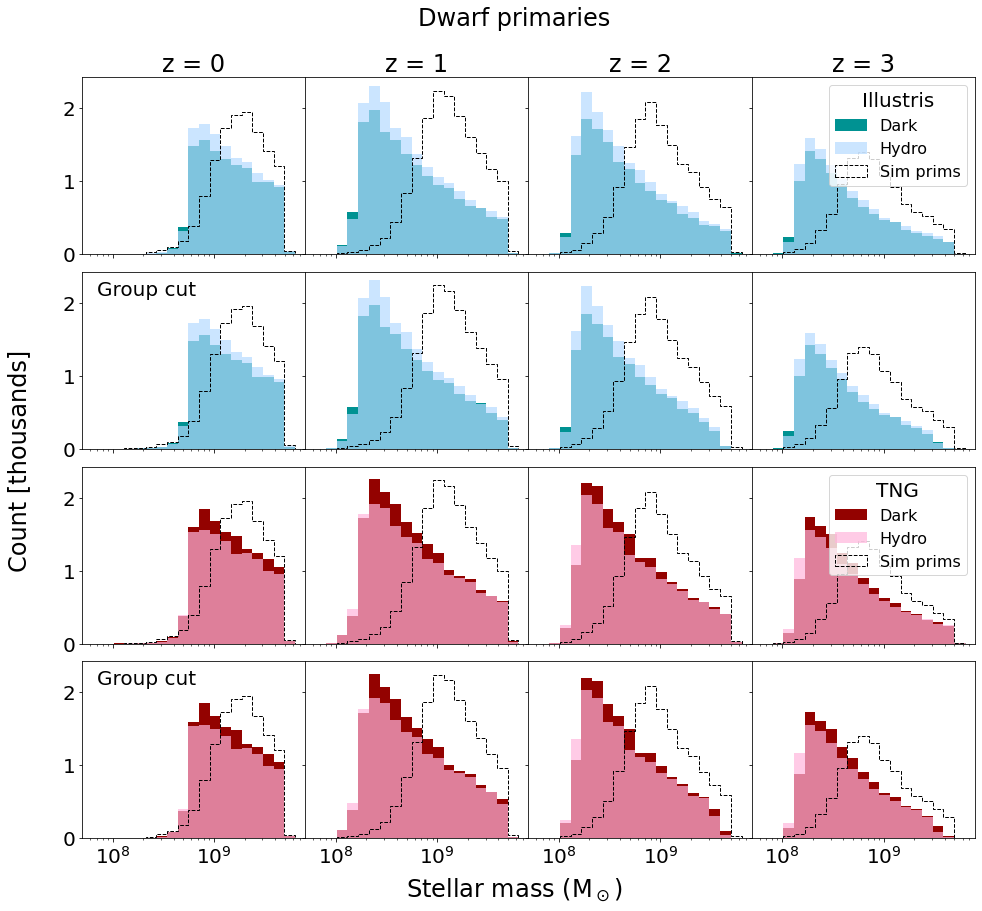

In [19]:
# dwarf primary 

# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(7.8,9.8,20)
weight = 1000
key = "Sub1 Stellar Mass"
size = "dwarf"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_primaries("Illustris","dark", size, i, key, median=True)*1e10
    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10    
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType")[:,4]*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    masses = get_primaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType",groupCut=True)[:,4]*1e10    
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True)*1e10
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType")[:,4]*1e10    
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    
    masses = get_primaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType",groupCut=True)[:,4]*1e10   
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(7e7,2.1,"Group cut")
ax[3][0].text(7e7,2.1,"Group cut")

fig.suptitle("Dwarf primaries",y=0.95)
fig.supxlabel(r"Stellar mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Ms_med_d1.png",bbox_inches='tight',facecolor="white")
plt.show()

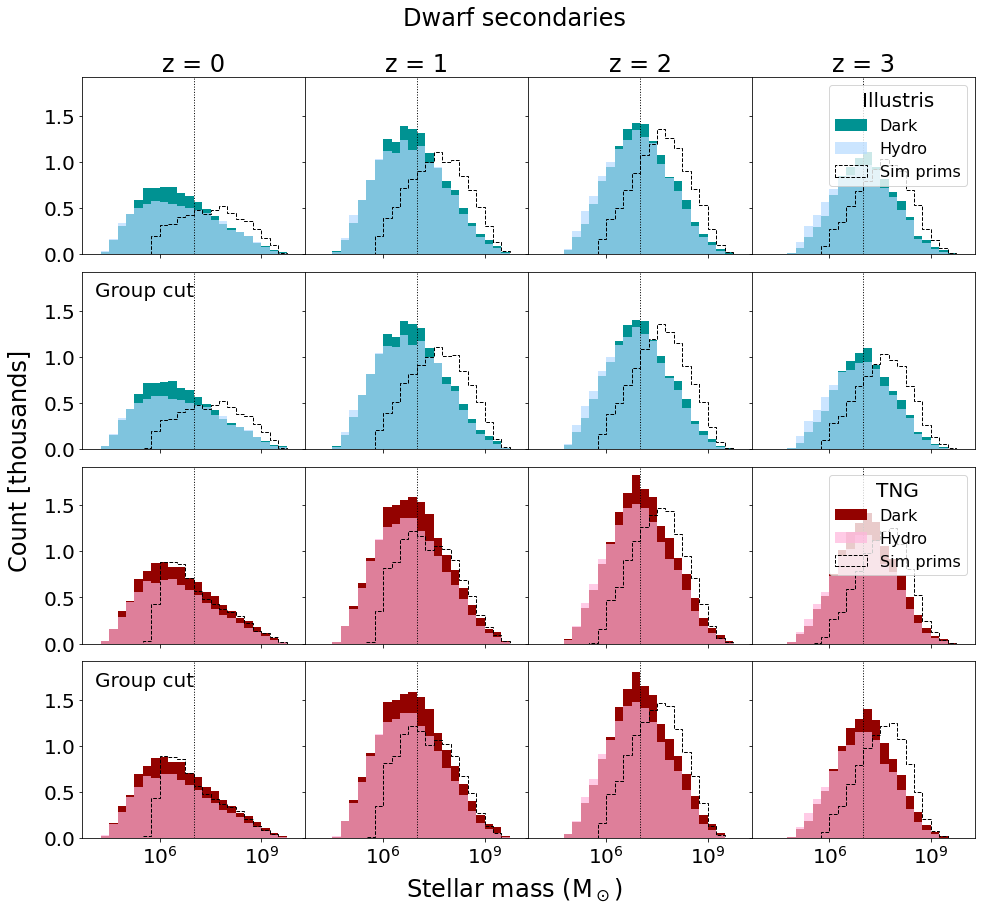

In [20]:
# secondary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(4,10,25)
weight = 1000
key = "Sub2 Stellar Mass"
size = "dwarf"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_secondaries("Illustris","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True)*1e10    
    masses_sim = get_secondaries_simstell("Illustris",size,i, "Sub2 MassType")[:,4]*1e10
    
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("Illustris",size,i, "Sub2 MassType",groupCut=True)[:,4]*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("TNG","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",size,i, "Sub2 MassType")[:,4]*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    

    masses = get_secondaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",size,i, "Sub2 MassType",groupCut=True)[:,4]*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

for i in range(4):
    for j in range(4):
        ax[i][j].axvline(1e7,linestyle='dotted',color='black',lw=1)

ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(1.2e4,1.65,"Group cut")
ax[3][0].text(1.2e4,1.65,"Group cut")

fig.suptitle("Dwarf secondaries",y=0.95)
fig.supxlabel(r"Stellar mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Ms_med_d2.png",bbox_inches='tight',facecolor="white")
plt.show()


## Massive

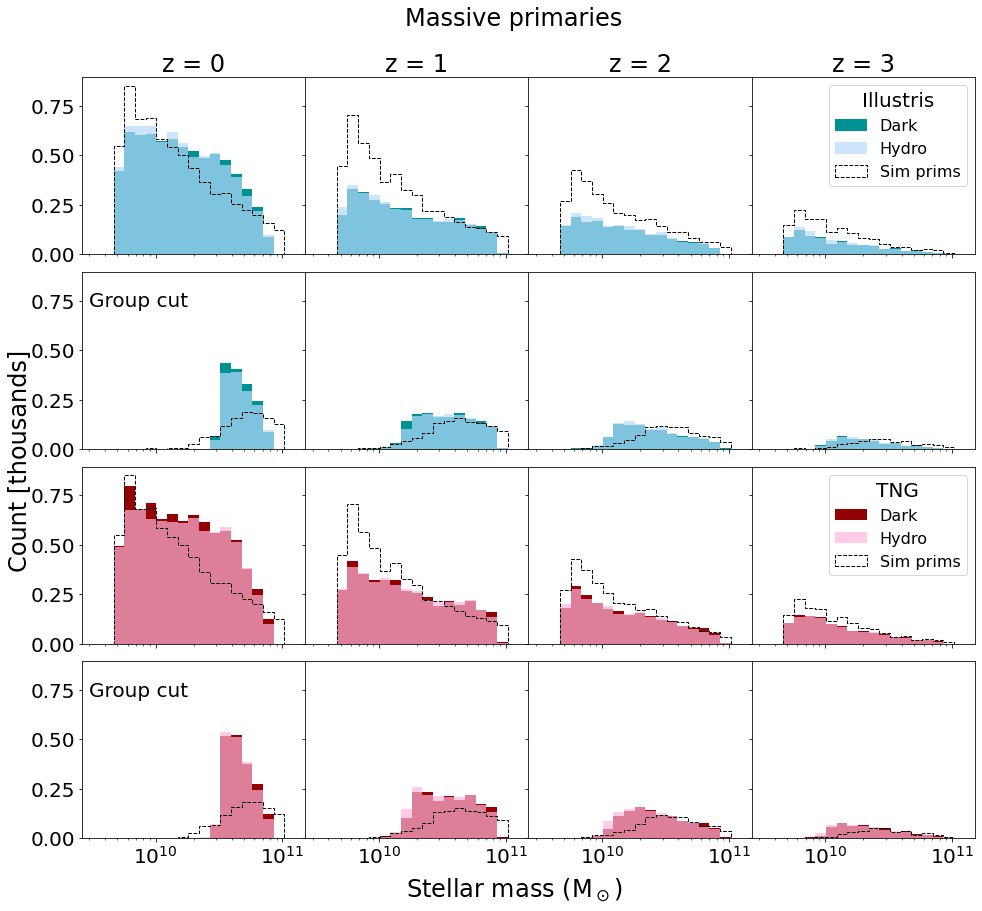

In [21]:
# massive primary 
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(9.5,11.1,20)
weight = 1000
key = "Sub1 Stellar Mass"
size = "massive"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_primaries("Illustris","dark", size, i, key, median=True)*1e10
    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10    
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType")[:,4]*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    masses = get_primaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType",groupCut=True)[:,4]*1e10    
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True)*1e10
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType")[:,4]*1e10    
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    
    masses = get_primaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_primaries_simstell("Illustris",size,i, "Sub1 MassType",groupCut=True)[:,4]*1e10   
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(3e9,0.72,"Group cut")
ax[3][0].text(3e9,0.72,"Group cut")

fig.suptitle("Massive primaries",y=0.95)
fig.supxlabel(r"Stellar mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Ms_med_m1.png",bbox_inches='tight',facecolor="white")
plt.show()

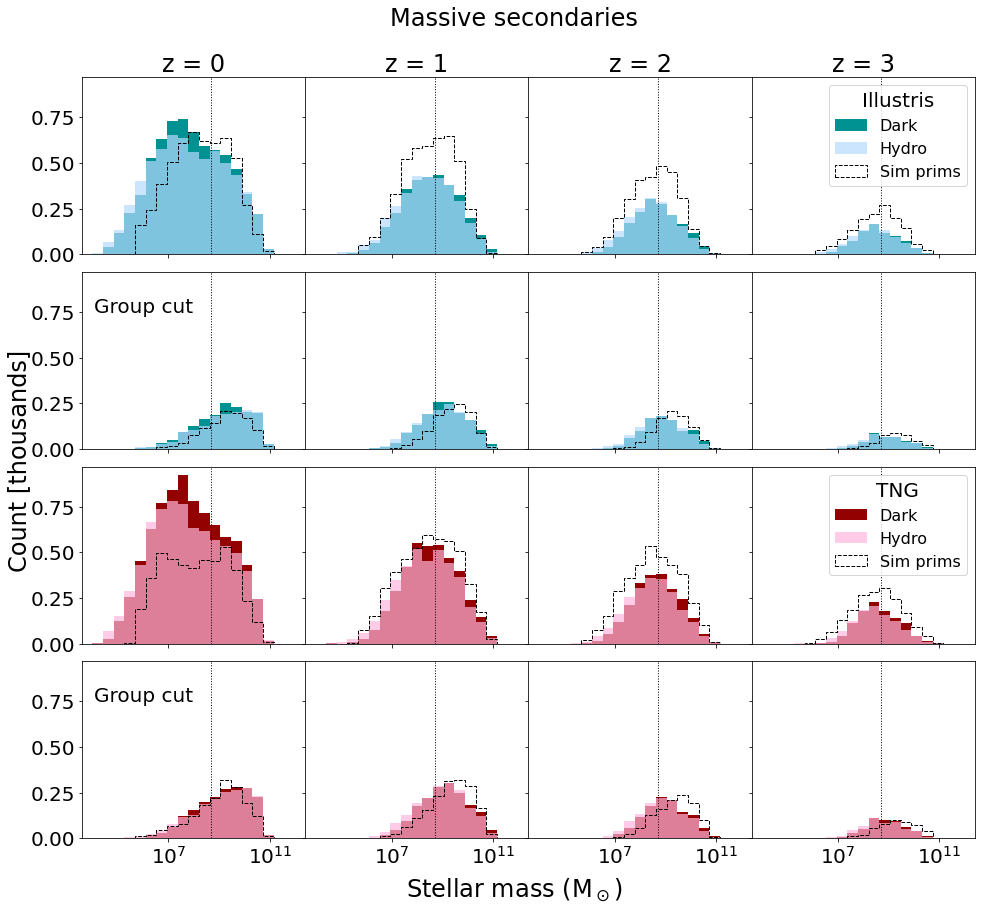

In [22]:
# secondary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(4,12,20)
weight = 1000
key = "Sub2 Stellar Mass"
size = "massive"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_secondaries("Illustris","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True)*1e10    
    masses_sim = get_secondaries_simstell("Illustris",size,i, "Sub2 MassType")[:,4]*1e10
    
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("Illustris",size,i, "Sub2 MassType",groupCut=True)[:,4]*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("TNG","dark", size, i, key, median=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",size,i, "Sub2 MassType")[:,4]*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    

    masses = get_secondaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10
    masses_sim = get_secondaries_simstell("TNG",size,i, "Sub2 MassType",groupCut=True)[:,4]*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

for i in range(4):
    for j in range(4):
        ax[i][j].axvline(5e8,linestyle='dotted',color='black',lw=1)

ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(1.2e4,0.75,"Group cut")
ax[3][0].text(1.2e4,0.75,"Group cut")

fig.suptitle("Massive secondaries",y=0.95)
fig.supxlabel(r"Stellar mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

plt.savefig(f"../plots/distributions/Ms_med_m2.png",bbox_inches='tight',facecolor="white")
plt.show()


# Separations

## Dwarfs

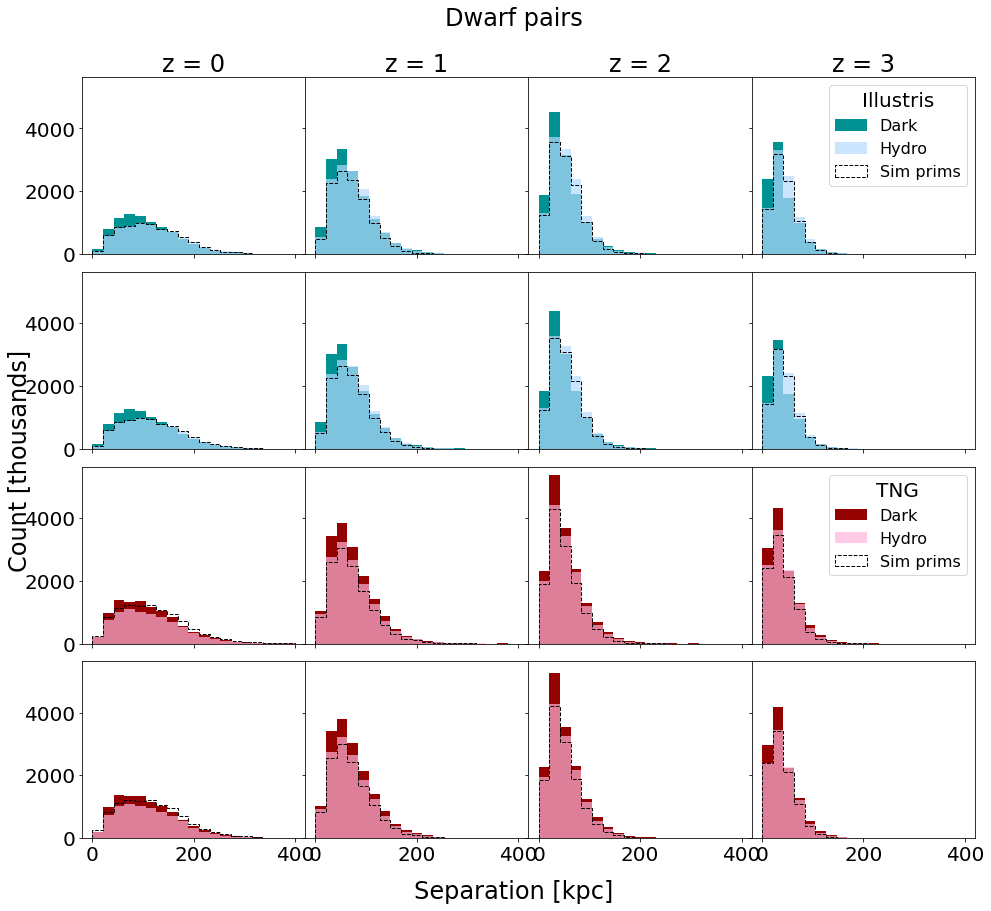

In [24]:
# secondary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.linspace(0,400,20)
weight = 1
key = "Separation"
size = "dwarf"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")

    masses = get_secondaries("Illustris","dark", size, i, key, median=True)
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True)
    masses_sim = get_secondaries_simstell("Illustris", size, i, key)
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("Illustris","dark", size, i, key, median=True,groupCut=True)
    masses_h = get_secondaries("Illustris","hydro", size, i, key, median=True,groupCut=True)
    masses_sim = get_secondaries_simstell("Illustris", size, i, key,groupCut=True)
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_secondaries("TNG","dark", size, i, key, median=True)
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True)
    masses_sim = get_secondaries_simstell("TNG",  size, i, key)
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    

    masses = get_secondaries("TNG","dark", size, i, key, median=True,groupCut=True)
    masses_h = get_secondaries("TNG","hydro", size, i, key, median=True,groupCut=True)
    masses_sim = get_secondaries_simstell("TNG",  size, i, key,groupCut=True)
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
# ax[1][0].text(1e9,1.55,"Group cut")
# ax[3][0].text(1e9,1.55,"Group cut")

fig.suptitle("Dwarf pairs",y=0.95)
fig.supxlabel(r"Separation [kpc]",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

# plt.savefig(f"../plots/distributions/Mh_med_d2.png",bbox_inches='tight',facecolor="white")
plt.show()

 
 ___
$ \quad$

$ \,\quad$


 
# Scratch work
## Investigating why the group cut decreases the massive galaxy sample so extremely ##

In the plots above, including the group cut BARELY changes the sample of dwarfs, but really effects the massive primaries and secondaries. Here, I will figure out what is causing that. 


In [24]:
sim = "Illustris"
snapshot = 135
phys = "hydro"
size = "massive"

In [ ]:
pair_path = f"{sim}_{snapshot}_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

paired = pair_data["pairs"][phys]
paired_stells = np.array(paired["Sub1 Stellar Mass"])

In [60]:
primary_mask = (paired_stells > 0.5) & (paired_stells < 10)
paired_median = np.array( paired['Realization'] ) ==-1

group_mask = get_groupmask(np.array(paired["Group Mass"]), size)
lowgroupmask = (np.array(paired["Group Mass"]) <= 100)
highgroupmask = (np.array(paired["Group Mass"]) >= 650)

low = np.sum(lowgroupmask & primary_mask  & paired_median)
high = np.sum(highgroupmask & primary_mask  & paired_median)
gr = np.sum(group_mask & primary_mask & paired_median)
al = np.sum(primary_mask  & paired_median)

# print(np.sum(group_mask & primary_mask & paired_median))
# print(np.sum(lowgroupmask & primary_mask  & paired_median))
# print(np.sum(highgroupmask & primary_mask  & paired_median))
# print(np.sum(primary_mask  & paired_median))
      
print("portion less than group mass cutoff", low/al)
print("portion within group mass cutoff", gr/al)
print("portion greater than group mass cutoff", high/al)
    

# paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
# paired_median = np.array( paired['Realization'] ) ==-1

portion less than group mass cutoff 0.7776739841195703
portion within group mass cutoff 0.22232601588042972
portion greater than group mass cutoff 0.0


halfway through writing the above code, I realized I could just make the distribution plots of the group mass for the answer. Anyways: based on the above, almost 80% of the sample of primaries lives in halos with mass < 1e12. 50% w mass less than 5e11.

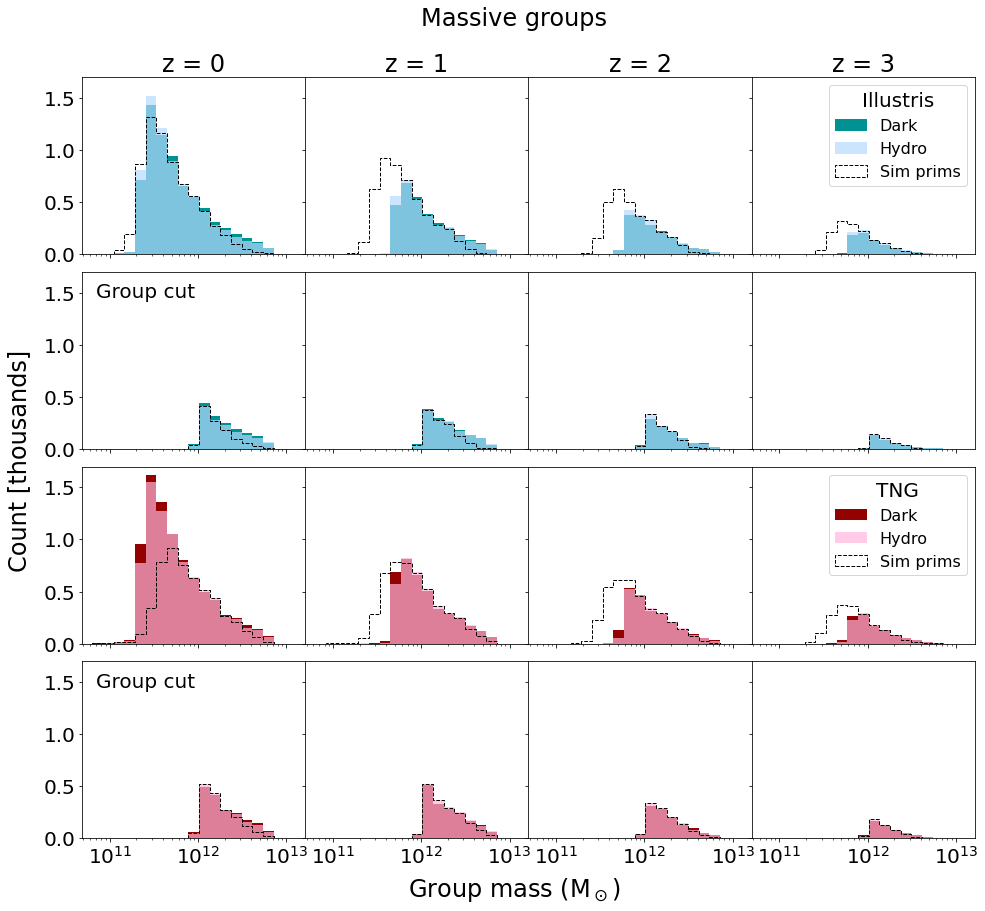

In [49]:
# primary log
fig, ax = plt.subplots(4,4,figsize=(16,14),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0,hspace=0.1)
bins = np.logspace(10.8,13.1,20)
weight = 1000
key = "Group Mass"
size = "massive"

for i in range(4):
    ax[0][i].set_title(f"z = {i}")
    ax[0][i].set_xscale('log')

    masses = get_primaries("Illustris","dark", size, i, key, median=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key)*1e10
    
    ax[0][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[0][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[0][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    masses = get_primaries("Illustris","dark", size, i, key, median=True,groupCut=True)*1e10

    masses_h = get_primaries("Illustris","hydro", size, i, key, median=True,groupCut=True)*1e10
    
    masses_sim = get_primaries_simstell("Illustris", size, i, key,groupCut=True)*1e10
    
    ax[1][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['Illustris dark'],label='Dark')
    ax[1][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['Illustris hydro'],alpha=0.7,label='Hydro')
    ax[1][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')

    
    masses = get_primaries("TNG","dark", size, i, key, median=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key)*1e10
    
    ax[2][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[2][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[2][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')
    
    masses = get_primaries("TNG","dark", size, i, key, median=True,groupCut=True)*1e10
    
    masses_h = get_primaries("TNG","hydro", size, i, key, median=True,groupCut=True)*1e10

    masses_sim = get_primaries_simstell("TNG",  size, i, key,groupCut=True)*1e10
    
    ax[3][i].hist(masses,weights=np.ones(len(masses))/weight, bins=bins, color=palette['TNG dark'],label='Dark')
    ax[3][i].hist(masses_h,weights=np.ones(len(masses_h))/weight, bins=bins, color=palette['TNG hydro'],alpha=0.7,label='Hydro')
    ax[3][i].hist(masses_sim,weights=np.ones(len(masses_sim))/weight, histtype='step', bins=bins, color="black",linestyle='dashed',label='Sim prims')


ax[0][3].legend(title="Illustris",fontsize=16)
ax[2][3].legend(title="TNG",fontsize=16)
ax[1][0].text(7e10,1.45,"Group cut")
ax[3][0].text(7e10,1.45,"Group cut")

fig.suptitle("Massive groups",y=0.95)
fig.supxlabel(r"Group mass ($\rm M_\odot$)",y=0.06)
fig.supylabel("Count [thousands]",x=0.060)

# plt.savefig(f"../plots/distributions/MG_med_m1.png",bbox_inches='tight',facecolor="white")
plt.show()

In [27]:
np.median(masses)

33.39698143709835

In [ ]:
np.median(masses)

# Other? 